In [5]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage #Needed to show molecules
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions #Only needed if mod
import numpy as np

In [ ]:
molecules = {
    "C11H24":"CCCCCCC(C)C(C)C",
    "C7H8N2O2":"ON(C1=CCC=C1)n1cco1",
    "C9H10N2O2PF2Cl":"OC(NC(Br)=CF)=C(O)C(F)NC=CC=CCl",
    "Cobimetinib MPO":"Cc1c(C2=Cc3ccccc3C2=O)ccc(Nc2ccc(F)cc2F)c1F",
    "Osimertinib MPO":"NS(=O)(=O)c1ncc(N2CCN(Cc3ccc4c(c3)OCC(=O)N4)CC2)n1Cc1nc2ccccc2[nH]1",
    "Fexofenadine MPO":"OCCCCCCCC1C=CC=C(CO)C1(O)c1ccccc1C1(CO)C(O)=CC=CC1CO",
    "Physchem MPO":"O=c1c(F)c1C1=C(CF)C(F)(c2c(F)c2=O)C(F)=C1C=C1C=c2c(=O)c2=C1F",
    "Ranolazine MPO":"CC=CNOCC(CC)CC1=C(CCC=C(C)C)CC(CC(=O)Nc2c(C)cccc2F)=CC1",
    "Celecoxib rediscovery":"Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)cc2)cc1",
    "Troglitazone rediscovery":"CC1=C(c2c(C)c2=O)C(C)(COc2ccc(Cc3c(C)c3=O)cc2)CC1",
    "Thiothixene rediscovery":"Cc1ccccc1-c1cc(S(=O)(=O)N(C)C)ccc1C=CCCN1CCN(C)CC1",
    "Aripiprazole similarity":"O=C1CCc2ccc(OCCCCCN3CCN(c4ccccc4Br)CC3)cc2N1",
    "Albuterol similarity":"CNCC(S)c1ccc(S)c(CS)c1",
    "Mestranol similarity":"COc1ccc2c(c1)CCC1CCC(C(C)(O)CO)CC21",
    "logP (target: -1.0)":"OCC#CC#CC#CC#CC#CC#CC#CC#CC1C#CC1O",
    "logP (target: 8.0)":"CNc1c(C)c(C)c(C2(c3c(C)c(C)c(C)c(Cl)c3C)C=C(C)C(C)=C2F)c(F)c1F",
    "TPSA (target: 150.0)":"NNC(ON)C(NN)ON=O",
    "CNS MPO":"c1ooc1CCCCCCCCC1=C(CCc2coo2)OOO1",
    "QED":"NC(=C(C1=CC2=CC=COC2O1)n1ccs1)n1ccs1",
    "Median molecules 1":"CC1CCC(C(C)C)C(O)C1",
}

In [ ]:
mols = []
legends = []
for legend in molecules.keys():
    mol = Chem.MolFromSmiles(molecules[legend])
    mols.append(mol)
    legends.append(legend)
MolsToGridImage(mols=mols, molsPerRow=5, legends=legends, maxMols=64)

In [ ]:
scores = np.array([0.9793076306438274,
          0.9969449194671987,
          0.8748955694520971,
          0.8974168076674003,
          0.8661837077363197,
          0.8458212661285781,
          0.9961750164080151,
          0.8717806102472373,
          1.0,
          0.4716981132075472,
          0.6732673267326733,
          0.9870709377258491,
          0.9956963247720907,
          0.7570410977606273,
          0.9999991691216573,
          0.99999317776361,
          0.9999875600203675,
          1.0,
          0.947761873398478,
          0.473429146593896])

In [ ]:
scores.sum()

In [2]:
from synergetic_molecule_generator.model import GAMoleculeModel
from synergetic_molecule_generator.swarm import Swarm
from deep_likeliness.discriminator import RNNEncoder
import torch
import numpy as np
import pandas as pd
from synergetic_molecule_generator.molecules import penalized_logP

class logpscorer:
    def __init__(self):
        pass

    def score_list(self, states):
        scores = []
        for s in states:
            scores.append(penalized_logP(s))
        return scores

# Env parameters
mutation_rate = 0.05

# Swarm parameters
n_walkers = 1024
balance = 1
n_cpu = 8

# NeuralNetwork
hidden_size = 256
num_layers = 2
biderectional = False

#saving paramters
parameter_file = "deep_scorer"

#Dataset to verify existing molecules
dataset = pd.read_csv('GAFractalMol/dataset_v1.csv')
dataset = dataset.to_numpy()
dataset = dataset[:, 0]
smile_dic = {}
for smile in dataset:
    smile_dic[smile] = True
dataset = smile_dic

model = GAMoleculeModel(mutation_rate=mutation_rate, n_cpu=n_cpu)

deep_scorer = RNNEncoder(hidden_size=hidden_size, num_layers=num_layers, bidirectional=biderectional)

deep_scorer.load_state_dict(torch.load("GAFractalMol/deep_likeliness/%s_network.pth" % parameter_file))

scorer = logpscorer()

wave = Swarm(model=model,
             neural_network=deep_scorer,
             scoring_function=scorer,
             n_walkers=n_walkers,
             render_every=1,
             balance=balance,
             accumulate_rewards=False)

states, rewards = wave.run_swarm_training(20000, reset=True, print_swarm=True)
states = states.tolist()

for sm in states:
    if sm in dataset.keys():
        states.remove(sm)

Environment: GA_molecule | Walkers: 1024 | clones 0
Total samples: 23552
Reward: mean 7.52 | Dispersion: 3.94 | max 10.73 | min 6.79 | std 0.64
Episode length: 23.00
Number unique molecules : 20676


In [3]:
rewards1 = (rewards[:, 0] - rewards[:, 0].mean()) / rewards[:, 0].std()
rewards2 = (rewards[:, 1] - rewards[:, 1].mean()) / rewards[:, 1].std()
new_rewards = rewards1 + rewards2

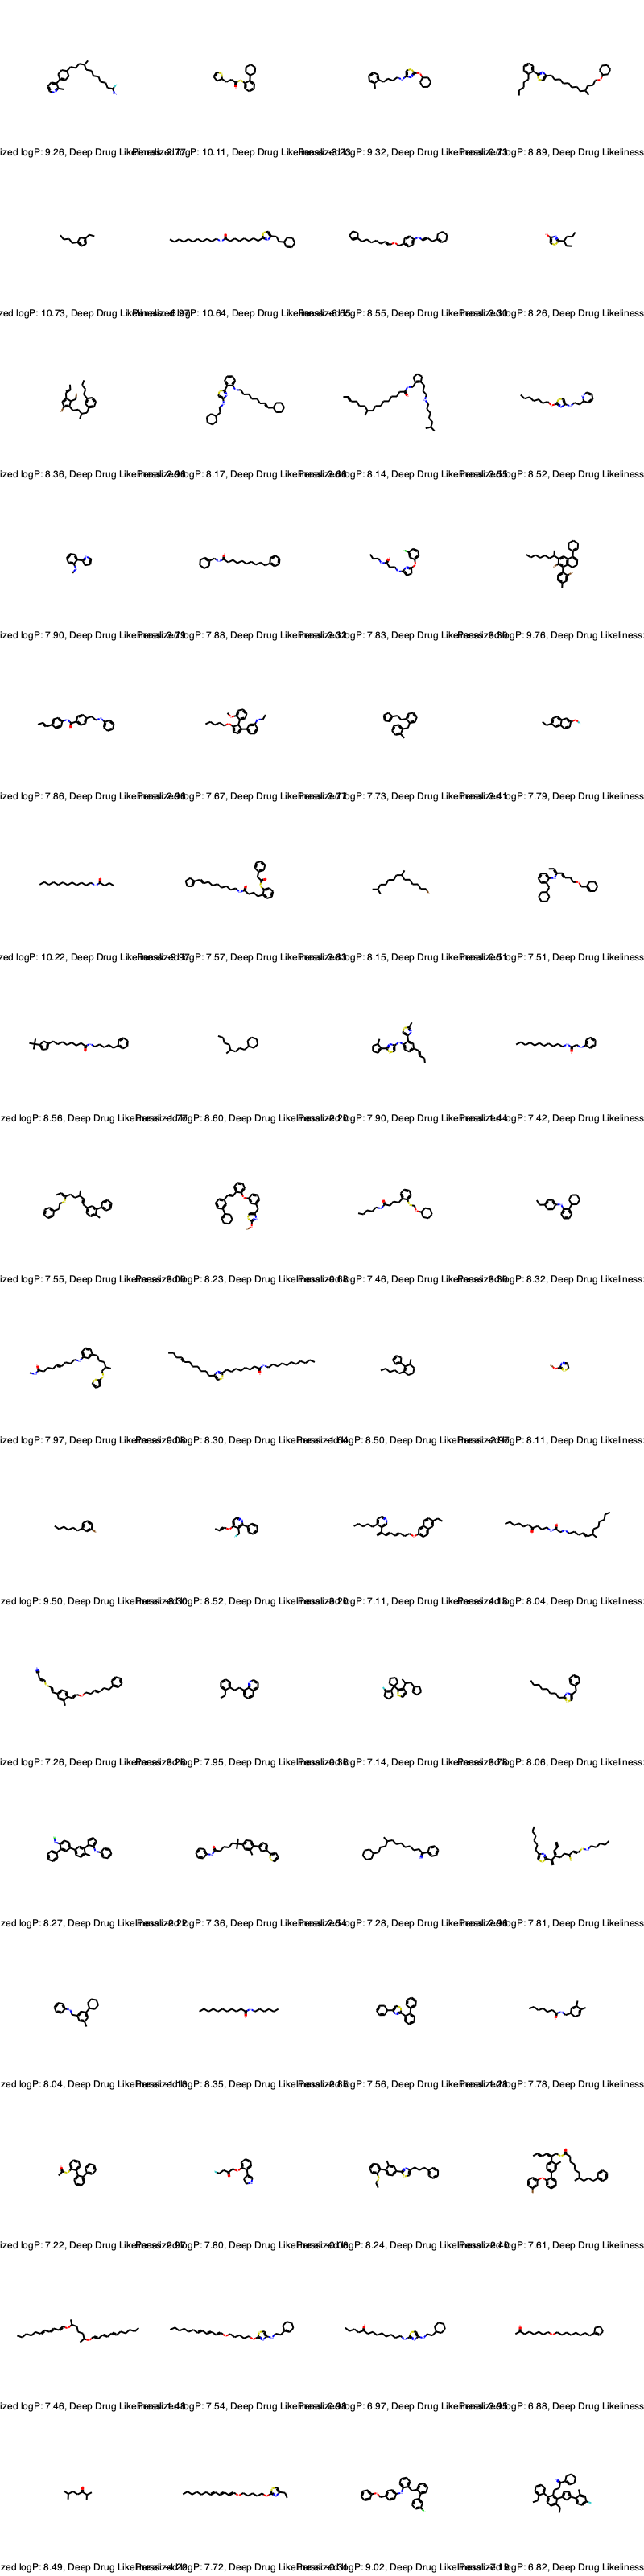

In [6]:
top_n = 64
molecules = []
legends = []
idx = (-new_rewards).argsort()[:top_n]
max_states = np.array(states)[idx]
max_rewards = rewards[idx]
for i in range(len(max_states)):
    molecule = Chem.MolFromSmiles(max_states[i])
    legend = "Penalized logP: {:.2f}, Likeliness: {:.2f}".format(max_rewards[i, 0], max_rewards[i, 1])
    molecules.append(molecule)
    legends.append(legend)
MolsToGridImage(mols=molecules, molsPerRow=4, legends=legends, maxMols=64)

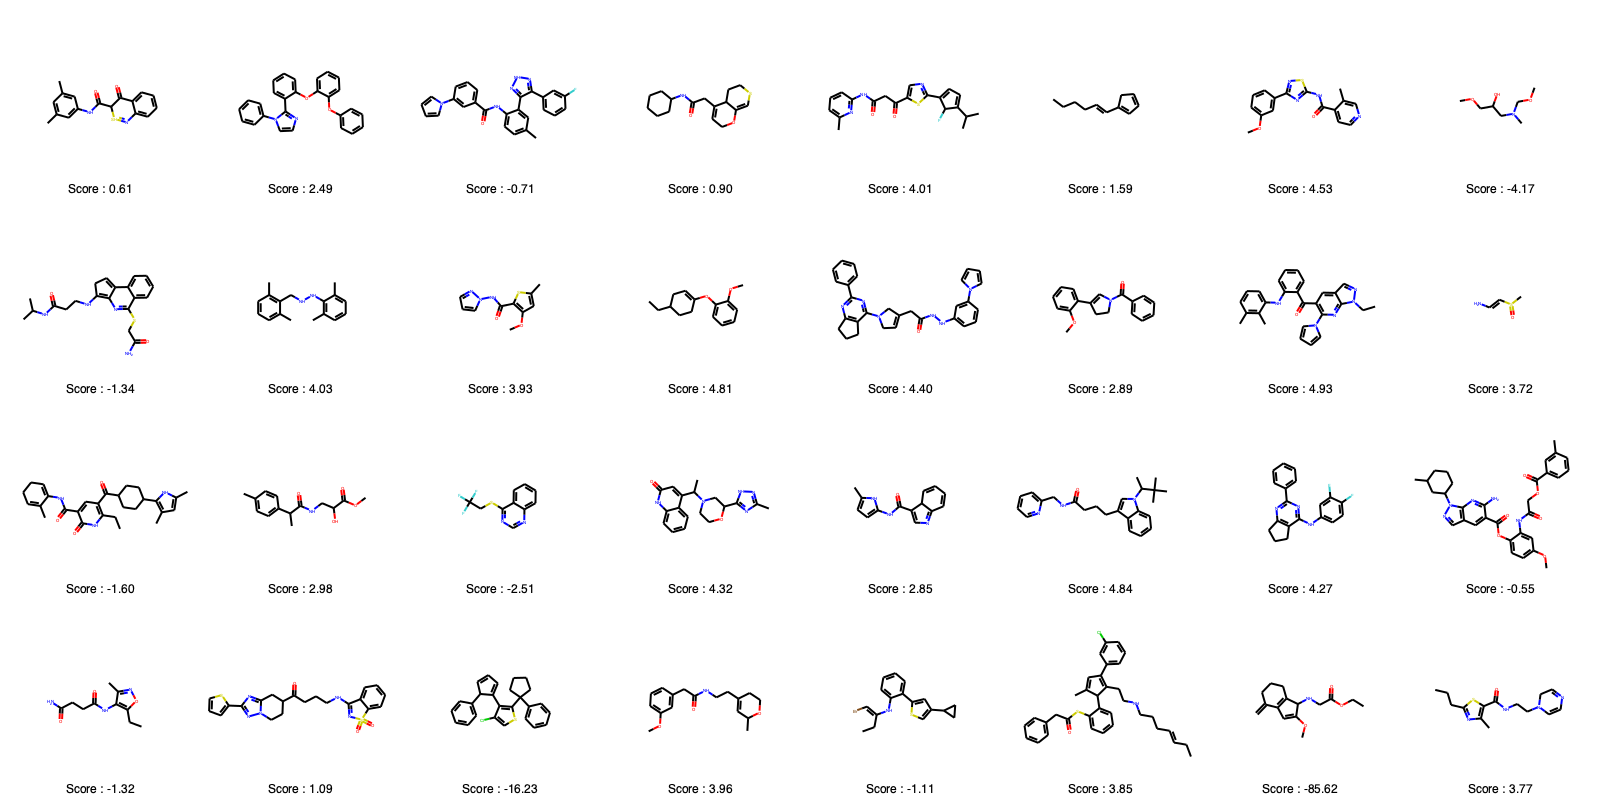

In [13]:
top_n = 32
molecules = []
legends = []
idx = (-rewards[:, 1]).argsort()[:top_n]
max_states = np.array(states)[idx]
max_rewards = rewards[idx]
for i in range(len(max_states)):
    molecule = Chem.MolFromSmiles(max_states[i])
    legend = "Score : {:.2f}".format(rewards[i, 1])
    molecules.append(molecule)
    legends.append(legend)
MolsToGridImage(mols=molecules, molsPerRow=8, legends=legends, maxMols=64)